In [58]:
from z3 import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from IPython.display import Image
import time

from decisiontree.dt_goal_recogniser import HandcraftedGoalTrees, TrainedDecisionTrees
from evaluation.verification import add_goal_tree_model, extract_counter_example, \
            extract_tree_counter_example, add_single_tree_model, verify_proposition
from core.data_processing import get_dataset
from core.feature_extraction import FeatureExtractor
from core.scenario import ScenarioConfig, Scenario
from core.base import get_data_dir, get_scenario_config_dir, get_img_dir
from core.lanelet_helpers import LaneletHelpers

## Handcrafted goal tree

In [2]:
scenario_name = 'heckstrasse'
model = HandcraftedGoalTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()



features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

# unsatisfiable if G2 always has highest prob
verify_expr = Implies(And(features[1]['in_correct_lane'], Not(features[2]['in_correct_lane'])), probs[2] < probs[1])
s.add(Not(verify_expr))

print(s.check())


unsat


verified true:
If car is in correct lane for G1, then G1 is predicted

In [3]:
scenario_name = 'heckstrasse'
model = HandcraftedGoalTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(Not(features[1]['in_correct_lane']),
                          features[2]['in_correct_lane']), probs[2] > probs[1])
s.add(Not(verify_expr))

print(s.check())

unsat


Verified true:
If car is in correct lane for G2, G2 is predicted


# Trained goal tree

In [4]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(features[1]['in_correct_lane'],
                          Not(features[2]['in_correct_lane'])),
                      probs[2] < probs[1])
s.add(Not(verify_expr))

print(s.check())

sat


In [5]:
extract_counter_example(s, features, probs, likelihoods)

,1,2
path_to_goal_length,78.0905,56.8645
in_correct_lane,True,False
speed,0,0
acceleration,-1,-1
angle_in_lane,0.03125,0.03125
vehicle_in_front_dist,0,0
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,None,8.7328
oncoming_vehicle_speed,None,0.029625
goal probability,0.297914,0.702086


In [6]:
likelihoods

{1: likelihood_1_straight-on, 2: likelihood_2_turn-left}

Verification failed: If car is in correct lane for G1, then G1 is predicted.
Becuase: The car is angled to the right (angle_in_lane	0.03125), and is still far from the goal (path_to_goal_length > x) (should replace this with distance to junction entry?), the car is not accelerating, there is no vehicle close in front.

G1 likelihood

## Investigate examples of this

In [7]:
dataset = get_dataset(scenario_name, 'train')

In [8]:
scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))

In [9]:
feature_extractor = FeatureExtractor(scenario.lanelet_map)

In [10]:
episode = scenario.load_episode(0)

In [11]:
state = episode.frames[8292].agents[114]

In [12]:
goal_routes = feature_extractor.get_goal_routes(state, scenario.config.goals)

ID -1770527: Linestring type must be specified
Found the following unknown types, did not plot them: ['wall', 'arrow']


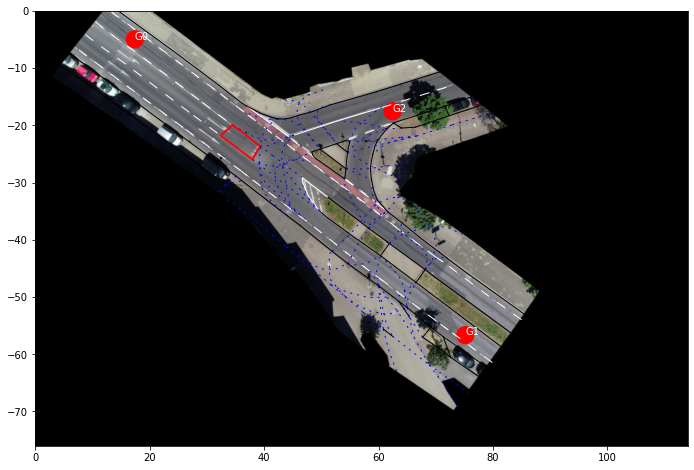

In [13]:
plt.figure(figsize=(12,8))
scenario.plot()
LaneletHelpers.plot(goal_routes[1].shortestPath()[0])

ID -1770527: Linestring type must be specified
Found the following unknown types, did not plot them: ['wall', 'arrow']


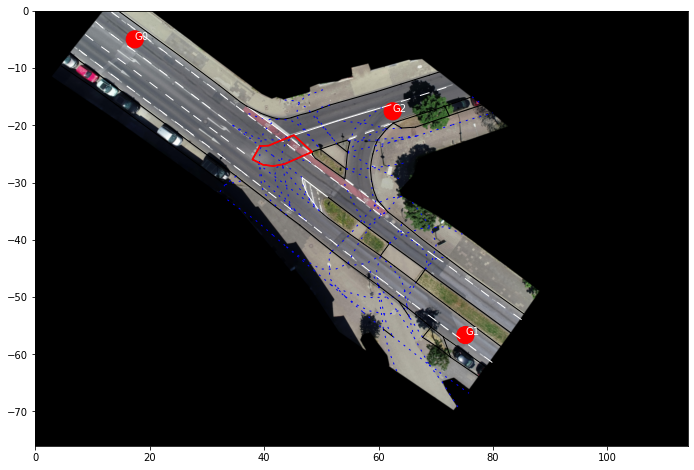

In [14]:
plt.figure(figsize=(12,8))
scenario.plot()
LaneletHelpers.plot(goal_routes[2].shortestPath()[0])

In [15]:
dataset.loc[(dataset.in_correct_lane)  
            & (dataset.angle_in_lane > 0.05)
           & (dataset.possible_goal==1) & (dataset.goal_type=='straight-on')]

,path_to_goal_length,in_correct_lane,speed,acceleration,angle_in_lane,vehicle_in_front_dist,vehicle_in_front_speed,oncoming_vehicle_dist,oncoming_vehicle_speed,goal_type,agent_id,possible_goal,true_goal,true_goal_type,frame_id,initial_frame_id,fraction_observed,episode
1103,57.251157,True,8.44261,0.94966,0.056181,17.078761,9.16979,100.0,20.0,straight-on,59,1,1,straight-on,3002,2932,0.7,2
1109,46.418964,True,9.55601,0.77053,0.054021,17.362261,9.41500,100.0,20.0,straight-on,59,1,1,straight-on,3032,2932,1.0,2
1237,48.281868,True,7.59623,1.78476,0.061450,37.811188,9.25895,100.0,20.0,straight-on,64,1,1,straight-on,3262,3192,1.0,2
1414,51.088326,True,4.15435,1.77150,0.055342,100.000000,20.00000,100.0,20.0,straight-on,72,1,1,straight-on,3762,3564,0.9,2
1416,46.693093,True,5.88367,2.04481,0.057562,100.000000,20.00000,100.0,20.0,straight-on,72,1,1,straight-on,3784,3564,1.0,2
2946,73.281020,True,10.46112,0.02086,0.050708,48.523105,14.39683,100.0,20.0,straight-on,144,1,2,turn-left,7494,7484,0.1,2
5632,45.574786,True,3.95654,1.10213,0.536447,23.787847,8.99368,100.0,20.0,straight-on,275,1,2,turn-left,14329,13669,1.0,2
7831,73.509990,True,13.70909,2.86297,0.056215,100.000000,20.00000,100.0,20.0,straight-on,402,1,1,straight-on,21862,21857,0.1,2
7833,70.671521,True,14.28047,2.33190,0.053617,100.000000,20.00000,100.0,20.0,straight-on,402,1,1,straight-on,21867,21857,0.2,2
8132,45.654696,True,4.55170,1.08278,0.533692,100.000000,20.00000,100.0,20.0,straight-on,420,1,2,turn-left,22817,22427,1.0,2


Reasons for wrong lane:
1. Start of trajectory, has not yet changed lane

heckstrasse agent 114 frame 8292 get current lanelet?


In [16]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)


verify_expr = Implies(And(Not(features[1]['in_correct_lane']), features[2]['in_correct_lane']), probs[2] > probs[1])
s.add(Not(verify_expr))

print(s.check())

unsat


Verified true: If car is in correct lane for G2, G2 is predicted

# Verify bound on probability if in the correct lane
If we are in the correct lane for a goal, the the probabilty of that goal should be > 0.2
Heckstrasse - coming from west

In [17]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)


verify_expr = Implies(And(features[1]['in_correct_lane'],
                          Not(features[2]['in_correct_lane'])), probs[1] >= 0.2)
s.add(Not(verify_expr))

print(s.check())

sat


In [18]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)


verify_expr = Implies(And(Not(features[1]['in_correct_lane']),
                          features[2]['in_correct_lane']), probs[2] >= 0.2)
s.add(Not(verify_expr))

print(s.check())

unsat


For both goals, this is verified to be true

# Verify prob based on angle in lane, approaching T Junction

In [19]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(0, 'turn-right'), (1, 'turn-left')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

s.add(features[0]['angle_in_lane'] >= np.pi / 8)
s.add(features[1]['angle_in_lane'] >= np.pi / 8)

verify_expr =  probs[1] >= 0.1
s.add(Not(verify_expr))

print(s.check())

sat


In [20]:
extract_counter_example(s, features, probs, likelihoods)

,0,1
path_to_goal_length,33.9457,53.4493
in_correct_lane,None,None
speed,7,7
acceleration,0.125,0.125
angle_in_lane,2,2
vehicle_in_front_dist,30.7327,30.7327
vehicle_in_front_speed,-1,-1
oncoming_vehicle_dist,-0.25,None
oncoming_vehicle_speed,None,5.72962
goal probability,0.985276,0.0147243


Becuase speed > 5.53
In the trainin set, all vehicles with speed > 5.53 turned right

# Verify that decreasing path to goal length leads to decreasing entropy
Can easily be done when there are two goals
Start with heckstrasse approaching from west

In [21]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

# 2 has shorter path to goal length than 1, but all other features are equal
features1, probs1, likelihoods1 = add_goal_tree_model(reachable_goals, s, model, suffix='_1')
features2, probs2, likelihoods2 = add_goal_tree_model(reachable_goals, s, model, suffix='_2')

for goal_idx, goal_type in reachable_goals:
    s.add(features1[goal_idx]['path_to_goal_length'] \
          > features2[goal_idx]['path_to_goal_length'])
    
    for feature_name in features1[goal_idx]:
        if feature_name != 'path_to_goal_length':
            s.add(features1[goal_idx][feature_name] == features2[goal_idx][feature_name])


verify_expr = And(Implies(probs1[1] < probs1[2], probs2[2] >= probs1[2]), 
                  Implies(probs1[1] > probs1[2], probs2[1] >= probs1[1]))

s.add(Not(verify_expr))


print(s.check())

sat


In [22]:
extract_counter_example(s, features1, probs1, likelihoods1)

,1,2
path_to_goal_length,0.125,57
in_correct_lane,False,False
speed,0,0
acceleration,2,2
angle_in_lane,-1,-1
vehicle_in_front_dist,0,0
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,0,8.7328
oncoming_vehicle_speed,0,0.029625
goal probability,0.0293569,0.970643


In [23]:
extract_counter_example(s, features2, probs2, likelihoods2)

,1,2
path_to_goal_length,-1,54
in_correct_lane,False,False
speed,0,0
acceleration,2,2
angle_in_lane,-1,-1
vehicle_in_front_dist,0,0
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,0,8.7328
oncoming_vehicle_speed,0,0.029625
goal probability,0.118171,0.881829


verification failed
Counterexample:
path_to_goal_length_1_1 = -1/4
path_to_goal_length_1_2 = -2

This features caused the difference:
path_to_goal_length_2_1 = 62
path_to_goal_length_2_2 = 59

likelihood_2_turn-left_1 = 0.032
likelihood_2_turn-left_2 = 0.002

likelihood_1_straight-on_1 = 0.0003
likelihood_1_straight-on_2 = 0.0003

in_correct_lane is false for both goals - should not be possible

## Try verification again, restricting feature values based on domain knowledge

Eventually domain model / feature extraction could be represented in logic

In [24]:
scenario_name = 'heckstrasse'
model = TrainedDecisionTrees.load(scenario_name)
reachable_goals = [(1, 'straight-on'), (2, 'turn-left')]

s = Solver()

# 2 has shorter path to goal length than 1, but all other features are equal
features1, probs1, likelihoods1 = add_goal_tree_model(reachable_goals, s, model, suffix='_1')
features2, probs2, likelihoods2 = add_goal_tree_model(reachable_goals, s, model, suffix='_2')

for goal_idx, goal_type in reachable_goals:
    s.add(features1[goal_idx]['path_to_goal_length'] \
          > features2[goal_idx]['path_to_goal_length'])
    
    for feature_name in features1[goal_idx]:
        if feature_name != 'path_to_goal_length':
            s.add(features1[goal_idx][feature_name] == features2[goal_idx][feature_name])

s.add(features1[1]['in_correct_lane'] != features1[2]['in_correct_lane'])

            
verify_expr = And(Implies(probs1[1] < probs1[2], probs2[2] >= probs1[2]), 
                  Implies(probs1[1] > probs1[2], probs2[1] >= probs1[1]))


print(verify_proposition(s, verify_expr))

False


In [25]:
extract_counter_example(s, features1, probs1, likelihoods1)

,1,2
path_to_goal_length,79,57
in_correct_lane,True,False
speed,0,0
acceleration,-1,-1
angle_in_lane,0.03125,0.03125
vehicle_in_front_dist,0,0
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,0,8.7328
oncoming_vehicle_speed,0,0.029625
goal probability,0.297914,0.702086


In [26]:
extract_counter_example(s, features2, probs2, likelihoods2)

,1,2
path_to_goal_length,76,56
in_correct_lane,True,False
speed,0,0
acceleration,-1,-1
angle_in_lane,0.03125,0.03125
vehicle_in_front_dist,0,0
vehicle_in_front_speed,0,0
oncoming_vehicle_dist,0,8.7328
oncoming_vehicle_speed,0,0.029625
goal probability,0.896721,0.103279


Not verified - different child node reached  depending path to goal length
When further from goal, acceleration is informative - high acceleration means lower G2 likelihood

Looks like overfitting - see tree below

# Bendplatz


ID -1766567: Linestring type must be specified
Found the following unknown types, did not plot them: ['wall', 'fence', 'arrow']


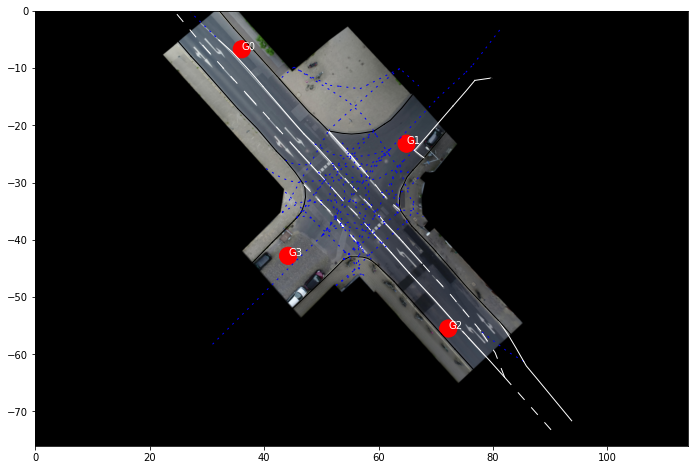

In [27]:
scenario_name = 'bendplatz'
scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))
plt.figure(figsize=(12,8))
scenario.plot()


If a vehicle is entering tyhe junction from the south-west, and it has stopped, and there is no oncming vehicle coming for G2, then goal should have low prob.

If a vehicle has stopped, but there is no oncoming vehicle for a particular goal, then that goal should have low probability.

In [28]:
model = TrainedDecisionTrees.load(scenario_name)

reachable_goals = [(0, 'turn-left'), (1, 'straight-on'), (2, 'turn-right')]

s = Solver()

features, probs, likelihoods = add_goal_tree_model(reachable_goals, s, model)

verify_expr = Implies(And(features[2]['speed'] < 1,
                          features[2]['oncoming_vehicle_dist'] > 80),
                          probs[2] < 0.9)
s.add(Not(verify_expr))

print(s.check())

sat


In [29]:
extract_counter_example(s, features, probs, likelihoods)

,0,1,2
path_to_goal_length,44,24,29
in_correct_lane,None,None,None
speed,0,0,0
acceleration,0,0,0
angle_in_lane,-0.0341797,-0.0341797,-0.0341797
vehicle_in_front_dist,12.3399,12.3399,12.3399
vehicle_in_front_speed,9.11146,9.11146,9.11146
oncoming_vehicle_dist,-1,0.25,81
oncoming_vehicle_speed,-0.25,1,6
goal probability,0.030721,0.0287252,0.940554


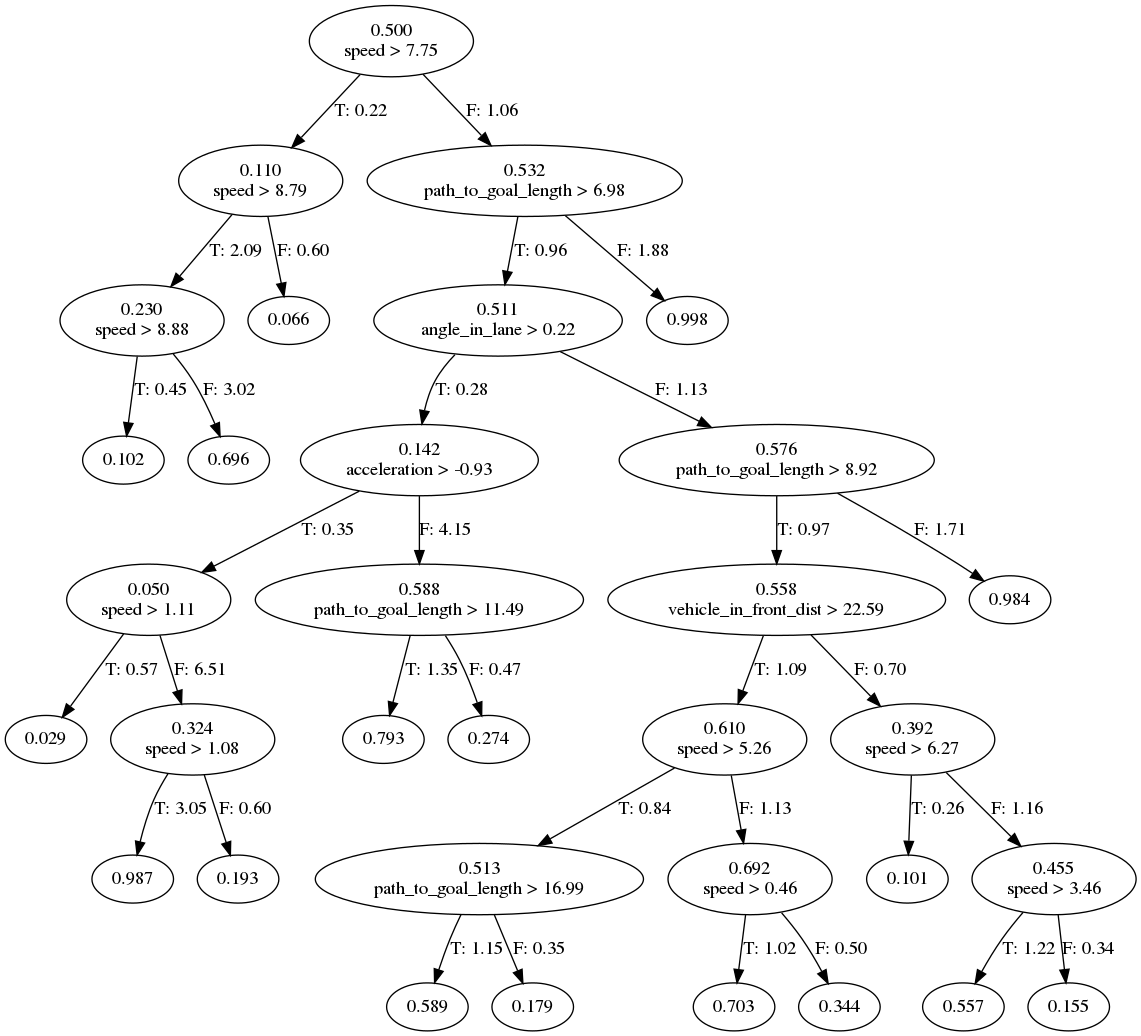

In [30]:
Image("../images/trained_tree_frankenberg_G2_turn-right.png")

oncoming vehicle dist feature is not even used in the decision tree


Instead, try: If a vehicle has stopped, then an oncoming vehicle should not decrease the goal likelihood

In [31]:
# 2 oncoming vehicle, but all other features are equal

reachable_goals = [(0, 'turn-left'), (1, 'straight-on'), (2, 'turn-right')]

s = Solver()

features1, probs1, likelihoods1 = add_goal_tree_model(reachable_goals, s, model, suffix='_1')
features2, probs2, likelihoods2 = add_goal_tree_model(reachable_goals, s, model, suffix='_2')

for goal_idx, goal_type in reachable_goals:
    
    s.add(features1[goal_idx]['speed'] < 1)

    
    for feature_name in features1[goal_idx]:
        
        if feature_name != 'oncoming_vehicle_dist':
            s.add(features1[goal_idx][feature_name] == features2[goal_idx][feature_name])
            
            
s.add(features1[2]['oncoming_vehicle_dist'] == 100)
s.add(features2[2]['oncoming_vehicle_dist'] < 50)

verify_expr = likelihoods2[2] >= likelihoods1[2]

s.add(Not(verify_expr))


print(s.check())


unsat


Verified true, but only because likelihood is independent of oncoming vehicle dist

Try verifying the same thing for Heckstrasse

ID -1770527: Linestring type must be specified
Found the following unknown types, did not plot them: ['wall', 'arrow']


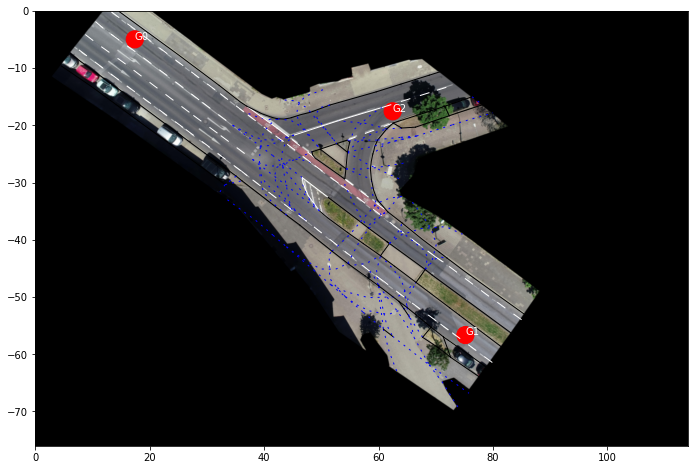

In [32]:
scenario_name = 'heckstrasse'
scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))
plt.figure(figsize=(12,8))
scenario.plot()
model = TrainedDecisionTrees.load(scenario_name)

In [33]:
reachable_goals = [(0, 'turn-right'), (1, 'turn-left')]

s = Solver()

features1, probs1, likelihoods1 = add_goal_tree_model(reachable_goals, s, model, suffix='_1')
features2, probs2, likelihoods2 = add_goal_tree_model(reachable_goals, s, model, suffix='_2')

for goal_idx, goal_type in reachable_goals:
    
    s.add(features1[goal_idx]['speed'] < 1)

    
    for feature_name in features1[goal_idx]:
        
        if feature_name != 'oncoming_vehicle_dist':
            s.add(features1[goal_idx][feature_name] == features2[goal_idx][feature_name])
            
            
s.add(features1[0]['oncoming_vehicle_dist'] == 100)
s.add(features2[0]['oncoming_vehicle_dist'] < 50)

verify_expr = likelihoods2[0] >= likelihoods1[0]

s.add(Not(verify_expr))


print(s.check())


sat


In [34]:
extract_counter_example(s, features1, probs1, likelihoods1)

,0,1
path_to_goal_length,33.9457,53.4493
in_correct_lane,False,False
speed,0.5,0.5
acceleration,3,3
angle_in_lane,0.25,0.25
vehicle_in_front_dist,30.7327,30.7327
vehicle_in_front_speed,-1,-1
oncoming_vehicle_dist,100,None
oncoming_vehicle_speed,0,5.72962
goal probability,0.384235,0.615765


In [35]:
extract_counter_example(s, features2, probs2, likelihoods2)

,0,1
path_to_goal_length,33.9457,53.4493
in_correct_lane,False,False
speed,0.5,0.5
acceleration,3,3
angle_in_lane,0.25,0.25
vehicle_in_front_dist,30.7327,30.7327
vehicle_in_front_speed,-1,-1
oncoming_vehicle_dist,27,None
oncoming_vehicle_speed,0,5.72962
goal probability,0.207337,0.792663


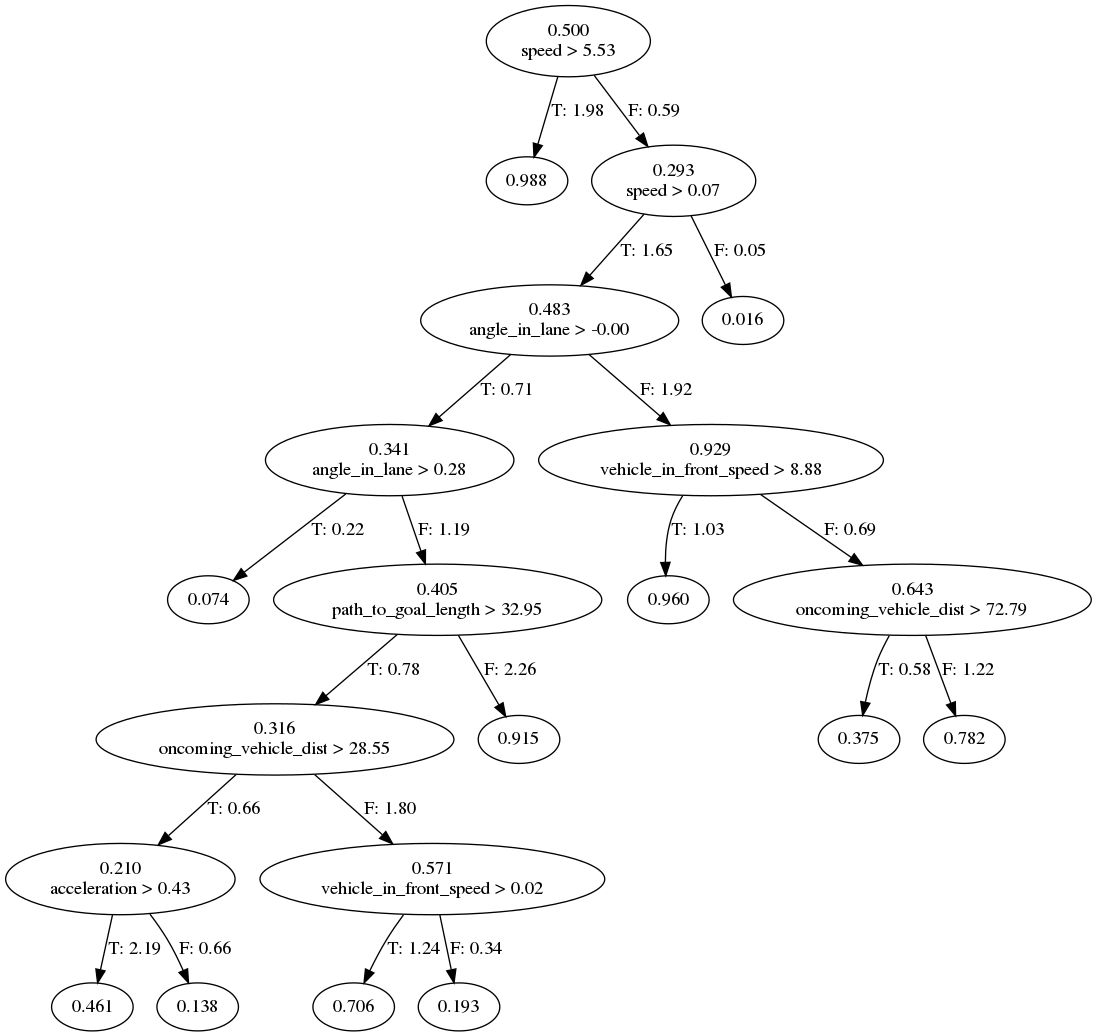

In [36]:
Image("../images/trained_tree_heckstrasse_G0_turn-right.png")

If a vehicle has stopped and there is not stopped vehicle in front, then an oncoming vehicle should not decrease the goal likelihood

In [37]:
reachable_goals = [(0, 'turn-right'), (1, 'turn-left')]

s = Solver()

features1, probs1, likelihoods1 = add_goal_tree_model(reachable_goals, s, model, suffix='_1')
features2, probs2, likelihoods2 = add_goal_tree_model(reachable_goals, s, model, suffix='_2')

for goal_idx, goal_type in reachable_goals:
    
    s.add(features1[goal_idx]['speed'] < 1)
    s.add(features1[goal_idx]['vehicle_in_front_speed'] > 5)

    
    for feature_name in features1[goal_idx]:
        
        if feature_name != 'oncoming_vehicle_dist':
            s.add(features1[goal_idx][feature_name] == features2[goal_idx][feature_name])
            
            
s.add(features1[0]['oncoming_vehicle_dist'] == 100)
s.add(features2[0]['oncoming_vehicle_dist'] < 50)

verify_expr = likelihoods2[0] >= likelihoods1[0]

s.add(Not(verify_expr))


print(s.check())

unsat


In [38]:
reachable_goals = [(0, 'turn-right'), (1, 'turn-left')]

s = Solver()

features1, prob1, likelihood1 = add_single_tree_model(0, 'turn-right', s, model, suffix='_1')
features2, prob2, likelihood2 = add_single_tree_model(0, 'turn-right', s, model, suffix='_2')

s.add(features1['speed'] < 1)
s.add(features1['vehicle_in_front_speed'] > 5)

    
for feature_name in features1:

    if feature_name != 'oncoming_vehicle_dist':
        s.add(features1[feature_name] == features2[feature_name])
            
s.add(features1['oncoming_vehicle_dist'] == 100)
s.add(features2['oncoming_vehicle_dist'] < 50)

verify_expr = likelihood2 >= likelihood1

s.add(Not(verify_expr))


print(s.check())

unsat


Successfully verified! Try verifying for all trees/scenarios.

In [39]:
#loop over all goal/goal type pairs in all scenarios

scenario

In [71]:
scenario_names = ['heckstrasse', 'bendplatz', 'frankenberg', 'round']

num_successful = 0

for scenario_name in scenario_names:
    model = TrainedDecisionTrees.load(scenario_name)
    scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))
    print(scenario_name)
    for goal_idx, goal_types in enumerate(scenario.config.goal_types):
        for goal_type in goal_types:
            s = Solver()

            features1, likelihood1, prob1 = add_single_tree_model(
                goal_idx, goal_type, s, model, suffix='_1')
            features2, likelihood2, prob2 = add_single_tree_model(
                goal_idx, goal_type, s, model, suffix='_2')

            s.add(features1['speed'] < 1)
            s.add(features1['vehicle_in_front_speed'] == 20)
            s.add(features1['vehicle_in_front_dist'] == 100)


            for feature_name in features1:

                if feature_name != 'oncoming_vehicle_dist':
                    s.add(features1[feature_name] == features2[feature_name])

            s.add(features1['oncoming_vehicle_dist'] == 100)
            s.add(features2['oncoming_vehicle_dist'] == 20)

            verify_expr = likelihood2 >= likelihood1
            success = verify_proposition(s, verify_expr)
            num_successful += int(success)
            print(goal_idx, goal_type, success)
print(num_successful, ' verifified successfully')

heckstrasse
0 turn-right True
0 straight-on True
1 turn-left True
1 straight-on True
1 u-turn True
2 turn-left True
2 turn-right True
bendplatz
0 turn-left True
0 turn-right True
0 straight-on True
1 turn-left True
1 turn-right True
1 straight-on True
2 turn-left True
2 turn-right True
2 straight-on True
3 turn-left True
3 turn-right True
3 straight-on True
frankenberg
0 turn-left True
0 turn-right True
0 straight-on True
1 turn-left True
1 turn-right True
1 straight-on True
2 turn-left True
2 turn-right True
2 straight-on False
3 turn-left True
3 turn-right True
3 straight-on True
round
0 turn-left True
0 turn-right True
0 straight-on True
0 u-turn True
1 turn-left True
1 turn-right True
1 straight-on True
1 u-turn True
2 turn-left False
2 turn-right True
2 straight-on True
2 u-turn True
3 turn-left False
3 turn-right False
3 straight-on True
3 u-turn True
43  verifified successfully


48 trees in total, 43 verified

bendplatz G3 straight-on: Lower likelihood if car is angled to the left - check both in case of oncoming vehicle and not oncoming, but different threshold

frankenberg G2 straight-on: Lower likelihood if there is an oncoming vehicle - doesn't make much sense, could be overfitting?



In [41]:
scenario_name = 'round'
model = TrainedDecisionTrees.load(scenario_name)
scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))

goal_idx = 2
goal_type = 'straight-on'
s = Solver()

features1, likelihood1, prob1 = add_single_tree_model(
    goal_idx, goal_type, s, model, suffix='_1')
features2, likelihood2, prob2 = add_single_tree_model(
    goal_idx, goal_type, s, model, suffix='_2')

s.add(features1['speed'] < 1)
s.add(features1['vehicle_in_front_speed'] == 20)
s.add(features1['vehicle_in_front_dist'] == 100)


for feature_name in features1:

    if feature_name != 'oncoming_vehicle_dist':
        s.add(features1[feature_name] == features2[feature_name])

s.add(features1['oncoming_vehicle_dist'] == 100)
s.add(features2['oncoming_vehicle_dist'] == 10)
verify_expr = likelihood2 >= likelihood1

s.add(Not(verify_expr))


print(goal_idx, goal_type, s.check())

2 straight-on sat


In [42]:
extract_tree_counter_example(s, features1, likelihood1)

path_to_goal_length              0
in_correct_lane              False
speed                            0
acceleration                     0
angle_in_lane                    0
vehicle_in_front_dist          100
vehicle_in_front_speed          20
oncoming_vehicle_dist          100
oncoming_vehicle_speed           0
goal likelihood           0.972356
dtype: object

In [43]:
extract_tree_counter_example(s, features2, likelihood2)

path_to_goal_length              0
in_correct_lane              False
speed                            0
acceleration                     0
angle_in_lane                    0
vehicle_in_front_dist          100
vehicle_in_front_speed          20
oncoming_vehicle_dist           10
oncoming_vehicle_speed           0
goal likelihood           0.805376
dtype: object

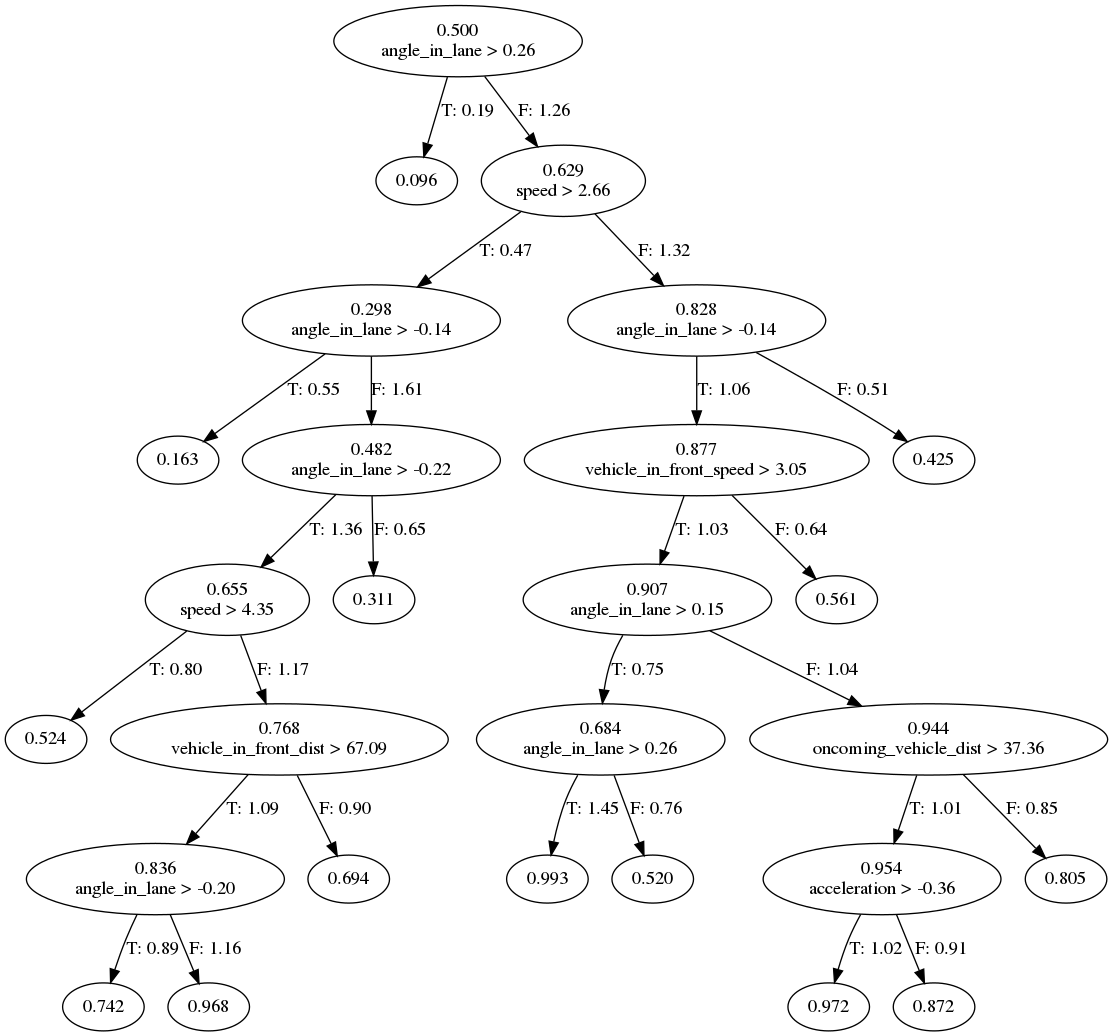

In [44]:
Image("../images/trained_tree_frankenberg_G2_straight-on.png")

Verify that being in the correct lane should have the same or higher likelihood than not being in the correct lane. - Failed when angle in in lane is turned.




In [45]:
scenario_names = ['heckstrasse', 'bendplatz', 'frankenberg', 'round']

for scenario_name in scenario_names:
    model = TrainedDecisionTrees.load(scenario_name)
    scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))
    print(scenario_name)
    for goal_idx, goal_types in enumerate(scenario.config.goal_types):
        for goal_type in goal_types:
            s = Solver()

            features1, likelihood1, prob1 = add_single_tree_model(
                goal_idx, goal_type, s, model, suffix='_1')
            features2, likelihood2, prob2 = add_single_tree_model(
                goal_idx, goal_type, s, model, suffix='_2')
            
            #s.add(features1['angle_in_lane'] == 0)


            for feature_name in features1:

                if feature_name != 'in_correct_lane':
                    s.add(features1[feature_name] == features2[feature_name])

            s.add(features1['in_correct_lane'] == False)
            s.add(features2['in_correct_lane'] == True)

            verify_expr = likelihood2 >= likelihood1

            verified = verify_proposition(s, verify_expr)


            print(goal_idx, goal_type, verified)

heckstrasse
0 turn-right True
0 straight-on True
1 turn-left True
1 straight-on True
1 u-turn True
2 turn-left False
2 turn-right True
bendplatz
0 turn-left True
0 turn-right True
0 straight-on True
1 turn-left False
1 turn-right True
1 straight-on True
2 turn-left True
2 turn-right True
2 straight-on False
3 turn-left False
3 turn-right True
3 straight-on True
frankenberg
0 turn-left True
0 turn-right True
0 straight-on True
1 turn-left True
1 turn-right True
1 straight-on True
2 turn-left True
2 turn-right True
2 straight-on True
3 turn-left True
3 turn-right True
3 straight-on True
round
0 turn-left True
0 turn-right True
0 straight-on True
0 u-turn True
1 turn-left True
1 turn-right True
1 straight-on True
1 u-turn True
2 turn-left True
2 turn-right True
2 straight-on True
2 u-turn True
3 turn-left True
3 turn-right True
3 straight-on True
3 u-turn True


Moslty true, but some exceptions:

Heckstrasse G2 turn-left - if the vehicle is heavily angled to the left, then being in the correct lane has a higher likelihood than not being in the correct lane.

Bendplatz G1 turn-left - If a vehicle is in the incorrect lane but deceleration sharply, then being in the correct lane has a higher likelihood than not being in the correct lane.

Bendplatz G2 straight-on - Higher likelihood if in incorrect lane and high speed and path_to_goal_length < 47.92 - could be overtaking in this situtation

Bendplatz G3 turn-left - Higher likelihood if low speed, angled to left and low speed oncoming vehicle, oncoming_vehicle_dist < -5.20? needs further investigation

In [46]:
scenario_name = 'bendplatz'
model = TrainedDecisionTrees.load(scenario_name)
scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))
goal_idx = 3
goal_type = 'turn-left'
s = Solver()

features1, likelihood1, prob1 = add_single_tree_model(
    goal_idx, goal_type, s, model, suffix='_1')
features2, likelihood2, prob2 = add_single_tree_model(
    goal_idx, goal_type, s, model, suffix='_2')

for feature_name in features1:

    if feature_name != 'in_correct_lane':
        s.add(features1[feature_name] == features2[feature_name])

s.add(features1['in_correct_lane'] == False)
s.add(features2['in_correct_lane'] == True)

verify_expr = likelihood2 >= likelihood1

s.add(Not(verify_expr))


print(goal_idx, goal_type, s.check())

3 turn-left sat


In [47]:
extract_tree_counter_example(s, features1, likelihood1)

path_to_goal_length          38.257
in_correct_lane               False
speed                       9.38193
acceleration                      0
angle_in_lane              0.113006
vehicle_in_front_dist             0
vehicle_in_front_speed            0
oncoming_vehicle_dist      -5.19652
oncoming_vehicle_speed    0.0932892
goal likelihood            0.981366
dtype: object

In [48]:
extract_tree_counter_example(s, features2, likelihood2)

path_to_goal_length          38.257
in_correct_lane                True
speed                       9.38193
acceleration                      0
angle_in_lane              0.113006
vehicle_in_front_dist             0
vehicle_in_front_speed            0
oncoming_vehicle_dist      -5.19652
oncoming_vehicle_speed    0.0932892
goal likelihood            0.889677
dtype: object

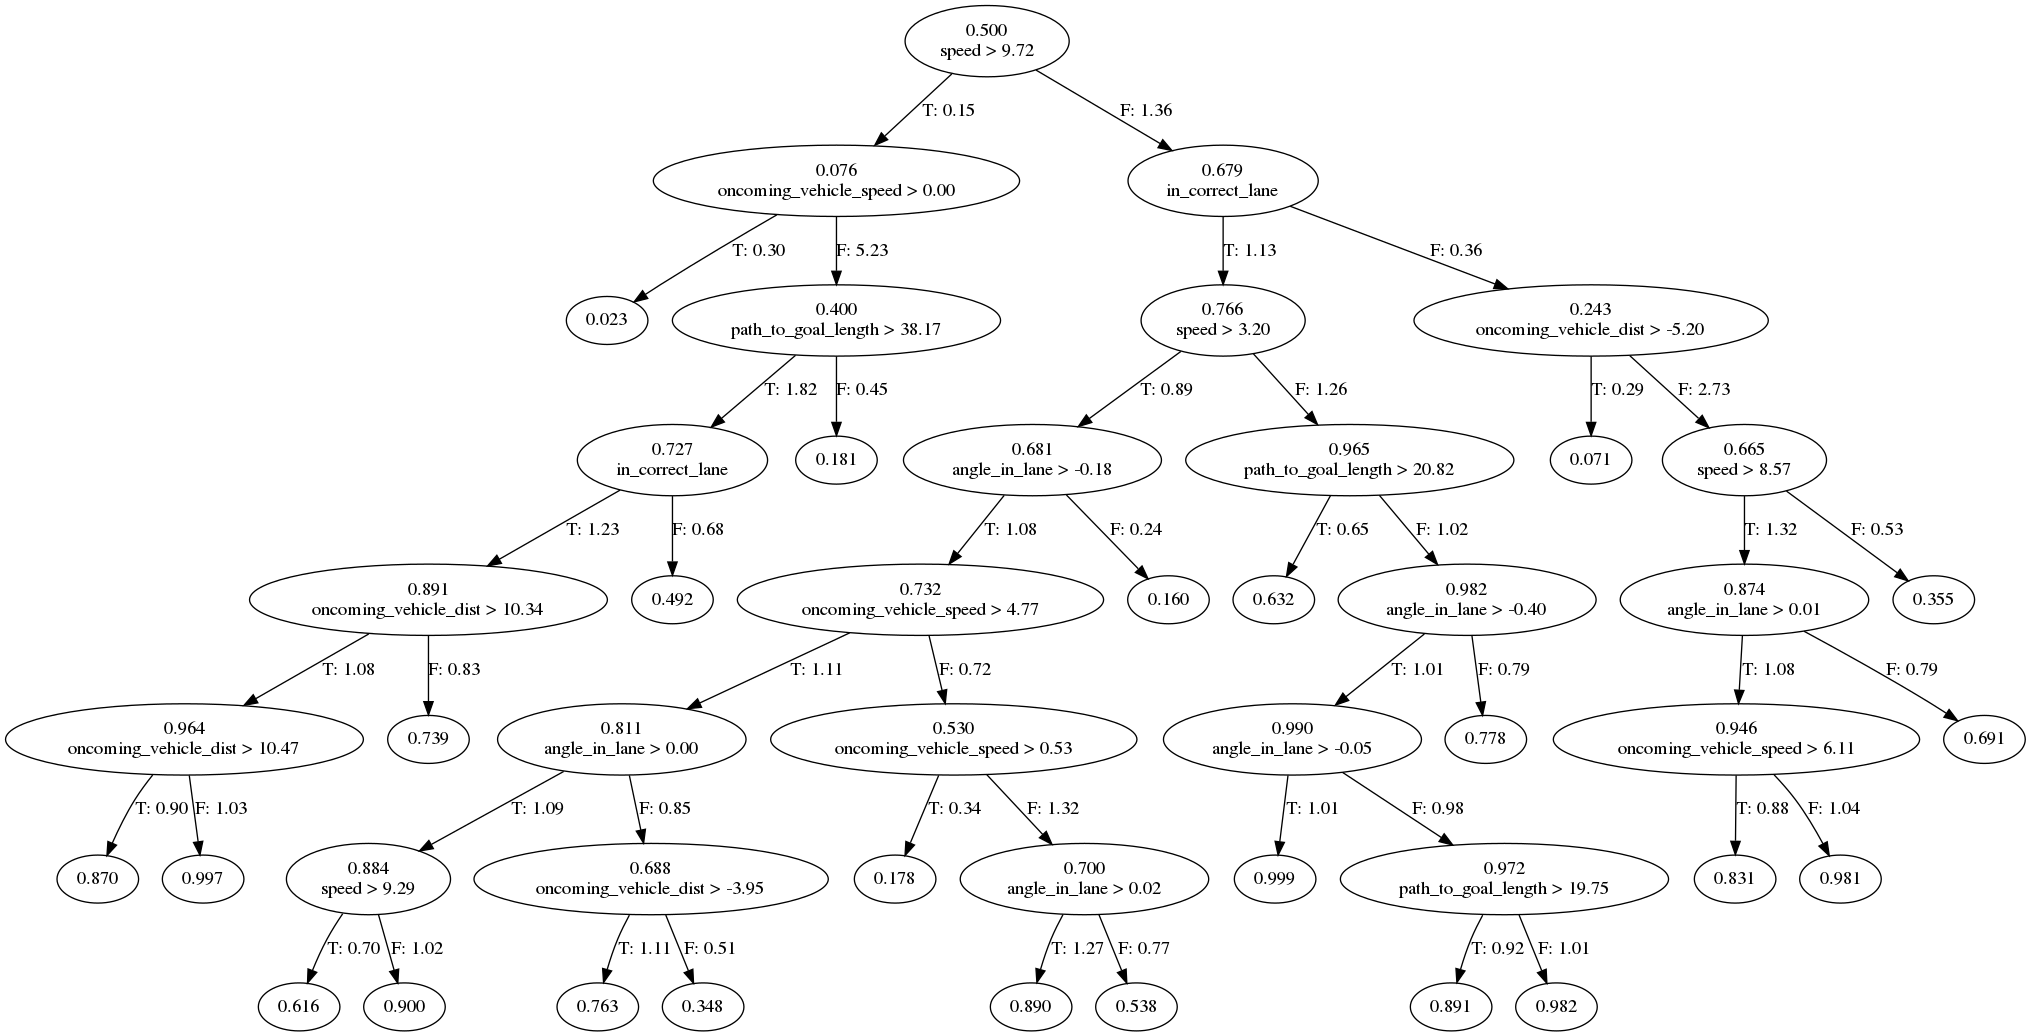

In [49]:
Image("../images/trained_tree_bendplatz_G3_turn-left.png")

If there is an oncoming vehicle for a goal, and the ego vehicle has stopped, then that goal should have the same or higher likelihood than if the vehicle had not stopped, all other features being unchanged

In [61]:
start = time.time()

scenario_names = ['heckstrasse', 'bendplatz', 'frankenberg', 'round']

for scenario_name in scenario_names:
    model = TrainedDecisionTrees.load(scenario_name)
    scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))
    print(scenario_name)
    for goal_idx, goal_types in enumerate(scenario.config.goal_types):
        for goal_type in goal_types:
            s = Solver()

            features1, likelihood1, prob1 = add_single_tree_model(
                goal_idx, goal_type, s, model, suffix='_1')
            features2, likelihood2, prob2 = add_single_tree_model(
                goal_idx, goal_type, s, model, suffix='_2')

            # no vehicle in front
            s.add(features1['vehicle_in_front_speed'] == 20)
            s.add(features1['vehicle_in_front_dist'] == 100)
            
            # there is an oncoming vehicle
            s.add(features1['oncoming_vehicle_dist'] == 20)
            s.add(features1['oncoming_vehicle_speed'] == 10)

            for feature_name in features1:

                if feature_name != 'speed':
                    s.add(features1[feature_name] == features2[feature_name])
            
            # not stopped
            s.add(features1['speed'] >= 1)
            
            # stopped
            s.add(features2['speed'] < 1)

            verify_expr = likelihood2 >= likelihood1

            s.add(Not(verify_expr))


            print(goal_idx, goal_type, s.check())

print('time taken: ', time.time() - start)

heckstrasse
0 turn-right sat
0 straight-on sat
1 turn-left unsat
1 straight-on unsat
1 u-turn unsat
2 turn-left unsat
2 turn-right unsat
bendplatz
0 turn-left unsat
0 turn-right sat
0 straight-on sat
1 turn-left sat
1 turn-right sat
1 straight-on sat
2 turn-left sat
2 turn-right unsat
2 straight-on sat
3 turn-left sat
3 turn-right sat
3 straight-on sat
frankenberg
0 turn-left sat
0 turn-right sat
0 straight-on sat
1 turn-left unsat
1 turn-right sat
1 straight-on sat
2 turn-left unsat
2 turn-right sat
2 straight-on sat
3 turn-left sat
3 turn-right sat
3 straight-on sat
round
0 turn-left sat
0 turn-right unsat
0 straight-on unsat
0 u-turn unsat
1 turn-left sat
1 turn-right unsat
1 straight-on sat
1 u-turn sat
2 turn-left sat
2 turn-right unsat
2 straight-on sat
2 u-turn sat
3 turn-left sat
3 turn-right unsat
3 straight-on unsat
3 u-turn unsat
time taken:  3.1327767372131348


heckstrasse 0 turn-right: tree does not depend on oncoming vehicles, only speed - 
any oncoming vehicles for this goal are also oncoming vehicles for other goals

In [62]:
scenario_name = 'heckstrasse'
goal_idx = 0
goal_type = 'turn-right'

model = TrainedDecisionTrees.load(scenario_name)
scenario = Scenario.load(get_scenario_config_dir() + '{}.json'.format(scenario_name))

s = Solver()

features1, likelihood1, prob1 = add_single_tree_model(
    goal_idx, goal_type, s, model, suffix='_1')
features2, likelihood2, prob2 = add_single_tree_model(
    goal_idx, goal_type, s, model, suffix='_2')

# no vehicle in front
s.add(features1['vehicle_in_front_speed'] == 20)
s.add(features1['vehicle_in_front_dist'] == 100)

# there is an oncoming vehicle
s.add(features1['oncoming_vehicle_dist'] == 20)
s.add(features1['oncoming_vehicle_speed'] == 10)

for feature_name in features1:

    if feature_name != 'speed':
        s.add(features1[feature_name] == features2[feature_name])

# not stopped
s.add(features1['speed'] >= 1)

# stopped
s.add(features2['speed'] < 1)

verify_expr = likelihood2 >= likelihood1

s.add(Not(verify_expr))


print(goal_idx, goal_type, s.check())

0 turn-right sat


In [63]:
extract_tree_counter_example(s, features1, likelihood1)

path_to_goal_length        33.9175
in_correct_lane              False
speed                      6.50162
acceleration                     0
angle_in_lane              1.24829
vehicle_in_front_dist          100
vehicle_in_front_speed          20
oncoming_vehicle_dist           20
oncoming_vehicle_speed          10
goal likelihood           0.987513
dtype: object

In [64]:
extract_tree_counter_example(s, features2, likelihood2)

path_to_goal_length         33.9175
in_correct_lane               False
speed                             0
acceleration                      0
angle_in_lane               1.24829
vehicle_in_front_dist           100
vehicle_in_front_speed           20
oncoming_vehicle_dist            20
oncoming_vehicle_speed           10
goal likelihood           0.0157248
dtype: object

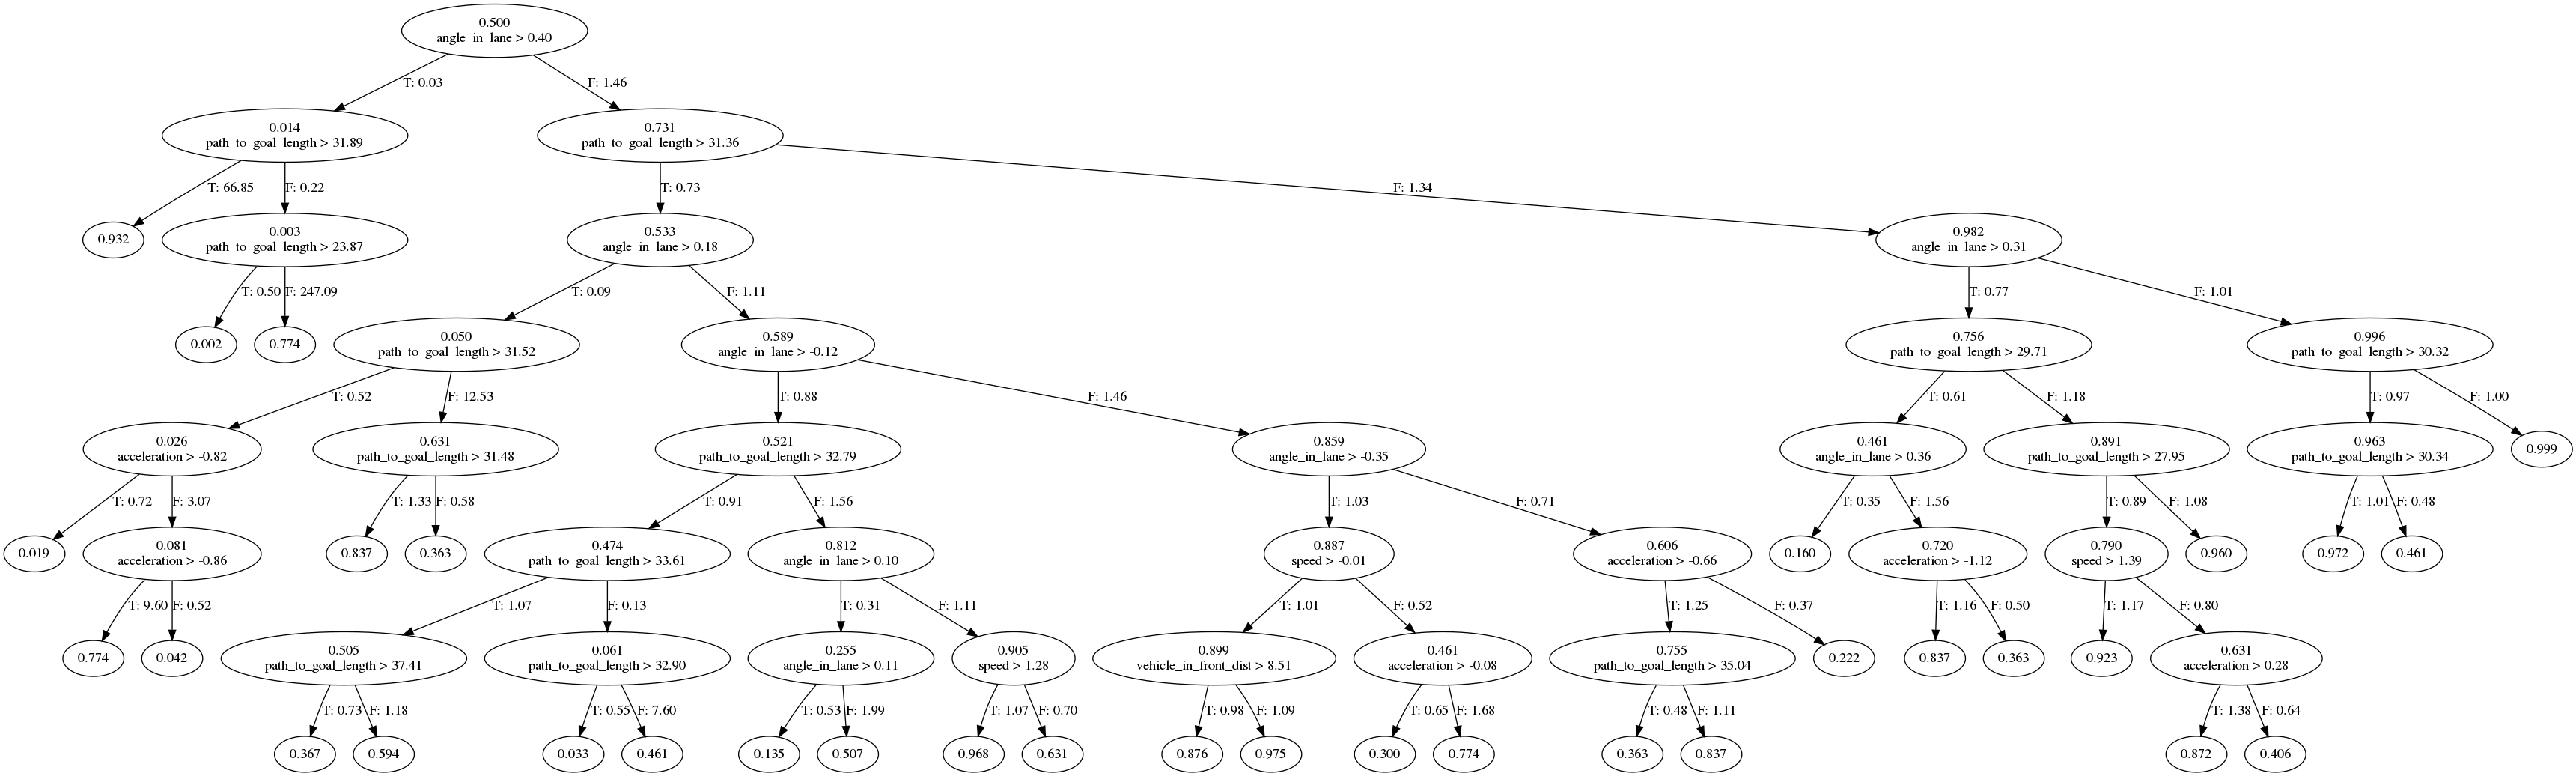

In [65]:
Image("../images/trained_tree_bendplatz_G0_turn-right.png")